# Fellowship.ai Challange

This notebook is for the Fellowship.ai challange. 

It uses the Omniglot dataset which contains 1623 handwritten characters from 50 different alphabets with 20 examples for each alphabet.

We will use two files from the dataset. They can be found by the following two links.
https://github.com/brendenlake/omniglot/blob/master/python/images_background.zip
https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip

The unzipped files saved in the datasets folder.


## Import necessary packages

In [1]:
import sys
import os
from scipy.misc import imread
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import tensorflow as tf


Using TensorFlow backend.


## Load the dataset

In [2]:
def load_data(path):
    datas=[]
    
    for alphas in os.listdir(path):
        if not alphas.startswith('.'):
            print('Loading alphabets from ' + alphas)
            alphas_path = os.path.join(path, alphas)
        
            for char in os.listdir(alphas_path):
                if not char.startswith('.'):
                    images_temp = []
                char_path = os.path.join(alphas_path, char)
            
                if not os.path.isdir(char_path):
                    continue
                
                for file in os.listdir(char_path):
                    if not file.startswith('.'):
                        image_path = os.path.join(char_path, file)
                        image = imread(image_path)
                
                        image = image / 255 #standardize image
                
                        images_temp.append(image)
                
                try:
                    datas.append(np.stack(images_temp))
                except ValueError as e:
                    print(e)
                    print("Error - Images category:", images_temp)

    datas = np.stack(datas)
    
    return datas

In [3]:
data_path = 'datasets/'
train_path = os.path.join(data_path, 'images_background')
val_path = os.path.join(data_path, 'images_evaluation')

print('Loading training data ...')
train_data = load_data(train_path)
print('Training data loaded. Data size', train_data.shape)

print('Loading evaluation data ...')
val_data = load_data(val_path)
print('Evaluation data loaded. Data size', val_data.shape)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Loading training data ...
Loading alphabets from Gujarati
Loading alphabets from Korean
Loading alphabets from Arcadian
Loading alphabets from Malay_(Jawi_-_Arabic)
Loading alphabets from Grantha
Loading alphabets from Blackfoot_(Canadian_Aboriginal_Syllabics)
Loading alphabets from Balinese
Loading alphabets from Futurama
Loading alphabets from N_Ko
Loading alphabets from Burmese_(Myanmar)
Loading alphabets from Anglo-Saxon_Futhorc
Loading alphabets from Mkhedruli_(Georgian)
Loading alphabets from Latin
Loading alphabets from Braille
Loading alphabets from Sanskrit
Loading alphabets from Japanese_(hiragana)
Loading alphabets from Tagalog
Loading alphabets from Greek
Loading alphabets from Ojibwe_(Canadian_Aboriginal_Syllabics)
Loading alphabets from Japanese_(katakana)
Loading alphabets from Early_Aramaic
Loading alphabets from Hebrew
Loading alphabets from Tifinagh
Loading alphabets from Asomtavruli_(Georgian)
Loading alphabets from Armenian
Loading alphabets from Syriac_(Estrangelo)

We notice that each example is a png file with 105 by 105 pixels in black and white.

## Helper functions

The following function generate the batch for each training iteration.

In [4]:
def batch(data, batch_size):
    n_classes, n_examples, w, h = data.shape
    
    ## Initialise the return dataset
    pairs=[np.zeros((batch_size, w, h, 1)) for i in range(2)]
    
    ## Make a target vector with half same (0) and half other (1) categories
    targets=np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    ## Pick the target categories of characters
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    
    for i in range(batch_size):
        category = categories[i]
        
        if targets[i] == 0: 
            category_2 = category # pick the same category
        else:
            ## pick a different category
            category_2 = (category + np.random.randint(1, n_classes)) % n_classes
        
        ## Choose two indixes of examples
        m = np.random.randint(0, n_examples)
        n = np.random.randint(0, n_examples)
        
        pairs[0][i,:,:,:] = data[category, m].reshape(w, h, 1)
        pairs[1][i,:,:,:] = data[category_2, n].reshape(w, h, 1)
  
    return pairs, targets

This function generate the evaluation samples, with the first one (of the support_set) matching the given character (test_image).

In [5]:
def oneshot_task(data, N):
    n_val, n_examples_val, w, h = data.shape

    categories = np.random.choice(n_val, size=(N,), replace=False)
    true_category = categories[0]
    
    indices = np.random.randint(0, n_examples_val, size=(N,))
    
    m, n = np.random.choice(n_examples_val, replace=False, size=(2,))
    
    ## Create a list with the same image N times as test image
    test_image = np.asarray([data[true_category, m, :,:]]*N).reshape(N, w, h, 1)
    
    support_set = data[categories, indices, :,:]
    
    ## Create the targets and fill in true character
    targets = np.zeros((N,))    
    targets[0] = 1 # Set the first target to be the true character
    support_set[0, :,:] = data[true_category, n] # Fill in this caracter
    
    ## Reshape the data
    support_set = support_set.reshape(N,w,h,1)
    pairs = [test_image, support_set]

    return pairs, targets

Pairs size 2


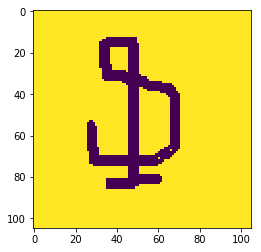

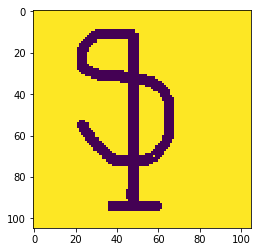

similarity/distance: 0.0


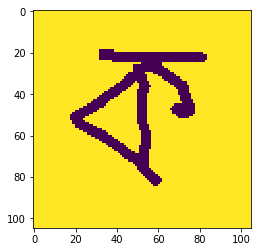

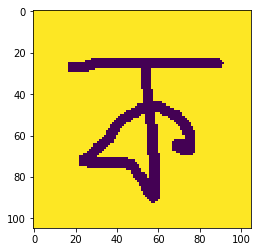

similarity/distance: 0.0


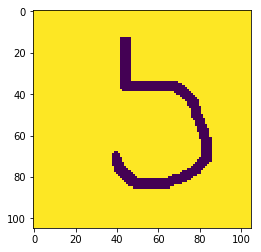

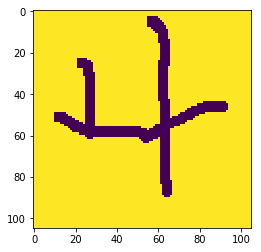

similarity/distance: 1.0


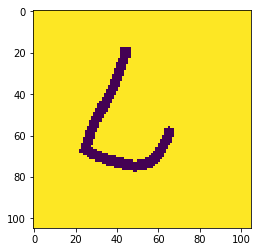

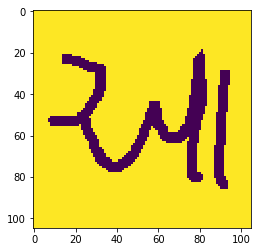

similarity/distance: 1.0


In [6]:
# test the helper function

pairs, targets = batch(train_data, 4)

print('Pairs size', len(pairs))

for i in range(len(pairs[0])):
    image = np.reshape(pairs[0][i],(105,105))
    plt.imshow(image)
    plt.show()
    image = np.reshape(pairs[1][i],(105,105))
    plt.imshow(image)
    plt.show()
    print("similarity/distance: " + str(targets[i]))

# Build the model with L_1 norm

We build the first model by the Siamese Neural Network idea. It is widely used for one-shot or few shot applications. The Siamese Newral Network will map a image to a multi-dimension vector. The goal is to minimize the distance between vectors corresponding to the same charactor while maximize the distance for vectors from different charactors.

In our first model, the siamese_network function maps each image to a 512 dimension vector. Then the prediction is made based on the L_1 distance between the target and the tested pair. The training of the model is set to minimize the standard MSE loss function.

When we evaluate or apply the model to a new charactor, we will use the trained siamese_network to generate the 512 dimension vector of the target charactor and the candidate charactor. The candidate with the shortest distance is considered a match.

In [7]:
def siamese_network(x_input, reuse):
    tf.summary.image('image_in'+str(reuse), x_input)
    
    with tf.variable_scope("shared_weights", reuse=reuse):
        conv1 = tf.layers.conv2d(x_input, 8, [10, 10], name='conv1', activation=tf.nn.relu)
        maxp1 = tf.layers.max_pooling2d(conv1, (2,2),(2,2), name='maxp1')
        
        conv2 = tf.layers.conv2d(maxp1, 16, [7, 7], name='conv2', activation=tf.nn.relu)
        maxp2 = tf.layers.max_pooling2d(conv2, (2,2),(2,2), name='maxp2')
        
        conv3 = tf.layers.conv2d(maxp2, 16, [4, 4], name='conv3', activation=tf.nn.relu)
        maxp3 = tf.layers.max_pooling2d(conv3, (2,2),(2,2), name='maxp3')

        conv4 = tf.layers.conv2d(maxp3, 32, [4, 4], name='conv4', activation=tf.nn.relu)
        flattened = tf.contrib.layers.flatten(conv4)
        
        dense1 = tf.layers.dense(flattened, 512, activation=tf.nn.sigmoid, name="dense1")          

    return dense1

In [8]:
# preparing for the training. Set log file number and configuration
log_n = 0
config = tf.ConfigProto()
config.gpu_options.allow_growth = True


In [9]:
tf.reset_default_graph()

image1 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1], name="image1")
image2 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1], name="image2")
label_placeholder = tf.placeholder(dtype=tf.float32, shape=[None,1], name="labels")

## Process both images, the second network use the same weights from the first network
out_1 = siamese_network(image1, None)
out_2 = siamese_network(image2, True)


In [ ]:
# calculate the distance
l_one = tf.abs(tf.subtract(out_1, out_2))
prediction = tf.layers.dense(l_one, 1, activation=tf.nn.sigmoid, name="output")
mseloss = tf.losses.mean_squared_error(label_placeholder, prediction)

optimizer = tf.train.AdamOptimizer().minimize(mseloss)

training_summary = tf.summary.scalar('mseloss', mseloss)
merged = tf.summary.merge_all()

## Train the model

In [11]:
writer = tf.summary.FileWriter(logdir='graphs/log/'+str(log_n), graph=tf.get_default_graph())
log_n += 1

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [12]:
batch_size = 32
iterations=5000

for iteration in tqdm(range(iterations)):
    pairs, targets = batch(train_data, batch_size)
    targets = [[t] for t in targets]
        
    _, summary = sess.run([optimizer, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
    writer.add_summary(summary, iteration)

100%|██████████| 5000/5000 [3:02:41<00:00,  2.17s/it]  


### Evaluate the model

Notice that input[0] repeats the target charactor N times and the first one of input[1] is the matching character. When calculating the distance between each pair of target and test characters, we find the shortest distance pair as the prediction. If it was the first pair, it is a correct prediction or a wrong one otherwise.

In [13]:
CHOOSE_FROM_N = 20
TEST_COUNT = 200

correct_tested = 0

for _ in tqdm(range(TEST_COUNT)):
    inputs, targets = oneshot_task(val_data, CHOOSE_FROM_N)
    pred = sess.run(prediction, 
                    feed_dict={image1: inputs[0], 
                               image2: inputs[1]})
    maxindex = np.argmin(pred)

    if maxindex == 0:
        correct_tested += 1
        
print("Accuracy in best of " + str(CHOOSE_FROM_N))
print(correct_tested/TEST_COUNT)

100%|██████████| 200/200 [01:32<00:00,  2.17it/s]

Accuracy in best of 20
0.73


## Build the model with contrastive loss

Instead of using the L_1 norm between vectors, we use the so called contrastive loss. The goal is to further distinguish the case with "same" charactor and "different" charactor. We want the same charactor has a closer distance while enlarge distance between different charactors. The formula can be found on:
https://www.quora.com/What-is-a-contrastive-loss-function-in-Siamese-networks


In [17]:
def contrastive_loss(vec1, vec2, labels, margin):
    y = tf.reshape(labels, [-1])
    with tf.name_scope("contrastive-loss"):
        l_two = tf.square(vec1-vec2)
        distance = tf.reduce_sum(l_two, axis=1)
        
        negative = (1-y) * distance
        positive = y * tf.maximum(0.0, margin - distance)
        
        contrastiveloss = negative + positive
        contrastiveloss = tf.reduce_mean(contrastiveloss)
    return contrastiveloss, distance

margin=1
contrastiveloss, distance = contrastive_loss(out_1, out_2, label_placeholder, margin)
contr_loss_summary = tf.summary.scalar('contrastiveloss', contrastiveloss)
merged = tf.summary.merge_all()

optimizer = tf.train.AdamOptimizer().minimize(contrastiveloss)

In [18]:
writer = tf.summary.FileWriter(logdir='graphs/log/'+str(log_n), graph=tf.get_default_graph())
log_n += 1

sess2 = tf.Session(config=config)
sess2.run(tf.global_variables_initializer())

In [21]:
BATCH_SIZE = 32

for iteration in tqdm(range(5000)):
    pairs, targets = batch(train_data, BATCH_SIZE)
    targets = [[t] for t in targets]
    _, summary = sess2.run([optimizer, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
    writer.add_summary(summary, iteration)

100%|██████████| 5000/5000 [3:02:08<00:00,  2.17s/it]  


## Evaluate the model

We use the same evaluating method as the base model. Notice that, though we train on the contrasive loss, we use the L_2 norm as the indication for the "closest" character. 

In [22]:
CHOOSE_FROM_N = 20
TEST_COUNT = 200
correct_tested = 0

for _ in tqdm(range(TEST_COUNT)):
    inputs, targets = oneshot_task(val_data, CHOOSE_FROM_N)
    dist = sess2.run(distance, feed_dict={image1: inputs[0], image2: inputs[1]})
    maxindex = np.argmin(dist)

    if maxindex == 0:
        correct_tested += 1
print("Accuracy in best of " + str(CHOOSE_FROM_N))
print(correct_tested/TEST_COUNT)

100%|██████████| 200/200 [01:32<00:00,  2.15it/s]

Accuracy in best of 20
0.72


# Further work

## Model with tripple lose function

The next model will utilize the so-called triplet loss. Instead of drawing pairs, we will train the model with triple samples: the target charactor, image from the same charactor and a different charactor. This idea is widely used in face recognition application, which a good example of one-shot seiamese neural network. For each triplet, we calculate the distance with the 'same' pair and the 'different' pair and make sure they are far-away enough.

This model will require the rewrite of the batch function. But we will still use the seiamese neural network architecure.